In [1]:

import os
import zipfile

try:
    import kaggle
except (OSError, ImportError):
    print("Kaggle library not found. Installing...")
    !pip install kaggle
    import kaggle

print("Kaggle library is ready and authenticated.")

# The slug of the dataset to download
dataset_slug = 'oddrationale/mnist-in-csv'

# Download the dataset if the zip file doesn't exist
if not os.path.exists('mnist-in-csv.zip'):
    print(f"Downloading dataset: '{dataset_slug}'...")
    kaggle.api.dataset_download_files(dataset_slug, path='.', unzip=False)
    print("Download complete.")
else:
    print("ZIP archive already exists.")

# Unzip the file if the CSVs are not present
if not (os.path.exists('mnist_train.csv') and os.path.exists('mnist_test.csv')):
    print("Unzipping the archive...")
    with zipfile.ZipFile('mnist-in-csv.zip', 'r') as zip_ref:
        # Rename files upon extraction to match our expected names
        for file_info in zip_ref.infolist():
            if 'train' in file_info.filename:
                file_info.filename = 'mnist_train.csv'
                zip_ref.extract(file_info, '.')
            elif 'test' in file_info.filename:
                file_info.filename = 'mnist_test.csv'
                zip_ref.extract(file_info, '.')
    print("Files extracted successfully.")
else:
    print("CSV files already exist and are extracted.")
    
print("\nDatasets are ready for use!")

Kaggle library is ready and authenticated.
Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
Download complete.
Unzipping the archive...
Files extracted successfully.

Datasets are ready for use!


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split # <--- NEW IMPORT
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# --- Data Loading and Concatenation ---
try:
    train_df = pd.read_csv('mnist_train.csv')
    test_df = pd.read_csv('mnist_test.csv')
    
    # NEW STEP: Concatenate the train and test sets into one large dataset
    full_df = pd.concat([train_df, test_df], ignore_index=True)
    print("Datasets loaded and concatenated successfully.")
    print(f"Total number of samples in the combined dataset: {len(full_df)}")

except FileNotFoundError:
    print("Error: CSV files not found. Please run the download cell first.")
    exit()

Datasets loaded and concatenated successfully.
Total number of samples in the combined dataset: 70000



--- Data Exploration (on the full combined dataset) ---
Distribution of labels in the full dataset:
label
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


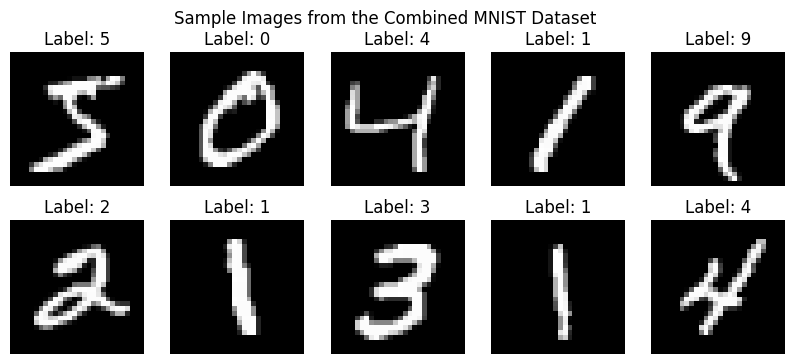

In [7]:
# --- 2.a. Data Exploration and Visualization (on the full dataset) ---
print("\n--- Data Exploration (on the full combined dataset) ---")
# As per the professor's request, analyze if the classes are balanced.
print(f"Distribution of labels in the full dataset:\n{full_df['label'].value_counts().sort_index()}")

# Separate features and labels for visualization purposes
X_full_raw = full_df.drop('label', axis=1).values
y_full_raw = full_df['label'].values

# Visualize a few sample digits from the combined dataset (no change in logic)
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_full_raw[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_full_raw[i]}")
    plt.axis('off')
plt.suptitle("Sample Images from the Combined MNIST Dataset")
plt.show()

In [8]:
# --- 2.c. Data Partitioning (The Experiment) ---
# NEW STEP: Split the combined dataset into new training and testing sets
# test_size=0.3 -> 30% for testing, 70% for training. You can experiment with this ratio (e.g., 0.2, 0.1).
# stratify=y_full_raw -> Ensures that the class distribution in the train and test sets is
#                      proportional to the distribution in the full dataset. This is crucial!
# random_state=42 -> Ensures that the split is the same every time you run the code, for reproducibility.
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_full_raw, y_full_raw, test_size=0.3, random_state=42, stratify=y_full_raw
)

print("\n--- Data Partitioning ---")
print(f"New training set shape: {X_train_raw.shape}")
print(f"New test set shape: {X_test_raw.shape}")


# --- Data Preprocessing (No change in logic) ---
# 1. Normalization
X_train = X_train_raw.astype('float32') / 255.0
X_test = X_test_raw.astype('float32') / 255.0

# 2. Reshaping for CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 3. One-Hot Encoding labels
y_train = to_categorical(y_train_raw, num_classes=10)
y_test = to_categorical(y_test_raw, num_classes=10)


--- Data Partitioning ---
New training set shape: (49000, 784)
New test set shape: (21000, 784)


In [9]:
# --- 2.d. Build the CNN Architecture (Using Input layer to avoid warnings) ---
model = Sequential([
    Input(shape=(28, 28, 1)), # Recommended modern approach
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,926 (702.84 KB)

 Trainable params: 179,926 (702.84 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- Compile and Train the Model (No change in logic) ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Model Training Started ---")
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_test, y_test))
print("--- Model Training Complete ---")


--- Model Training Started ---
Epoch 1/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8437 - loss: 0.5382 - val_accuracy: 0.9730 - val_loss: 0.0883
Epoch 2/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9778 - loss: 0.0705 - val_accuracy: 0.9794 - val_loss: 0.0635
Epoch 3/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9858 - loss: 0.0437 - val_accuracy: 0.9854 - val_loss: 0.0469
Epoch 4/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9896 - loss: 0.0327 - val_accuracy: 0.9856 - val_loss: 0.0439
Epoch 5/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9911 - loss: 0.0266 - val_accuracy: 0.9876 - val_loss: 0.0369
Epoch 6/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9941 - loss: 0.0187 - val_accuracy: 0.9858 - val_loss: 0.0466
Epoch 7/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9877 - val_loss: 0.0380
Epoch 8/15
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy:


Results on Test Data (with 70/30 split):
  - Loss: 0.0477
  - Accuracy: 0.9894 (98.94%)


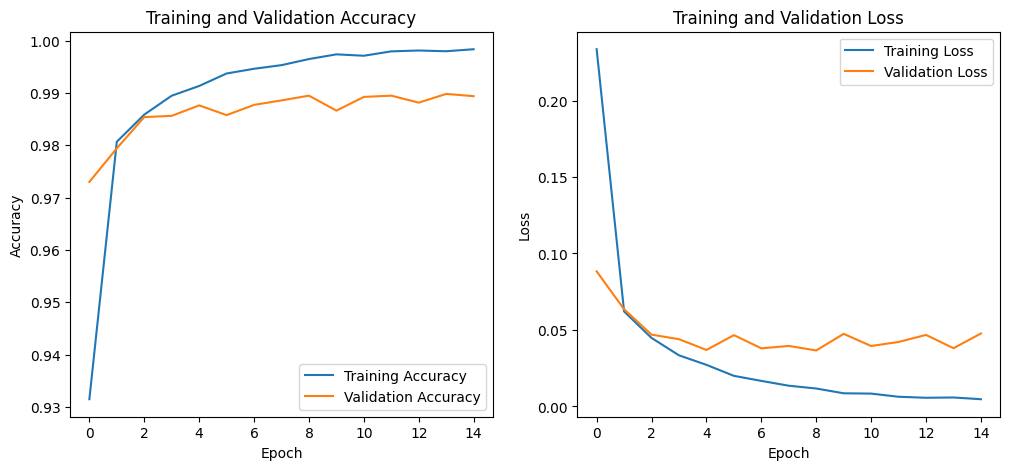

In [11]:
# --- 2.e. Visualize and Analyze the Results (No change in logic) ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nResults on Test Data (with 70/30 split):")
print(f"  - Loss: {loss:.4f}")
print(f"  - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


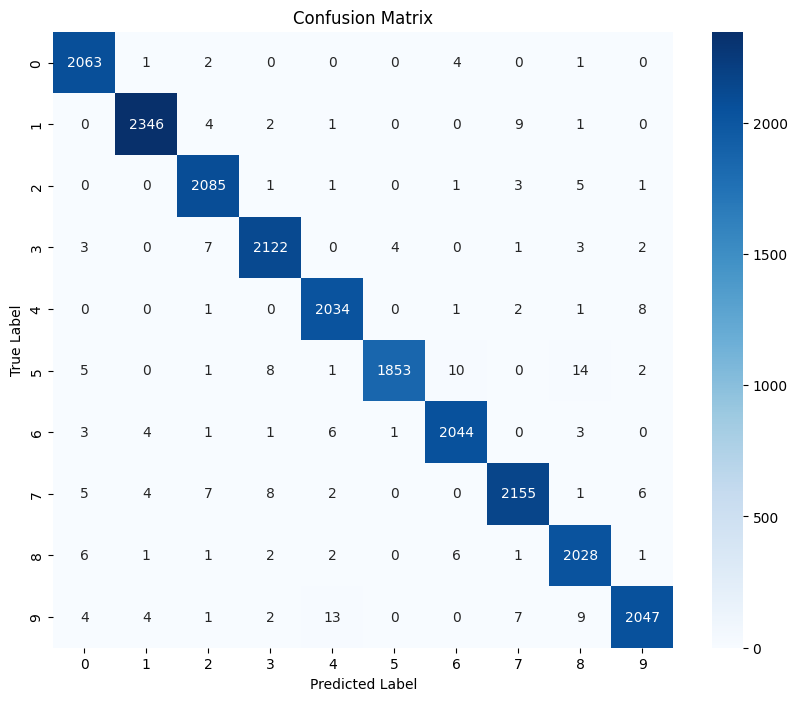


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2071
           1       0.99      0.99      0.99      2363
           2       0.99      0.99      0.99      2097
           3       0.99      0.99      0.99      2142
           4       0.99      0.99      0.99      2047
           5       1.00      0.98      0.99      1894
           6       0.99      0.99      0.99      2063
           7       0.99      0.98      0.99      2188
           8       0.98      0.99      0.99      2048
           9       0.99      0.98      0.99      2087

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



In [12]:
# Making predictions and generating reports
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=[str(i) for i in range(10)]))